In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from __future__ import print_function
import numpy as np
import cv2
import glob
import os
from sklearn.model_selection import train_test_split
np.random.seed(1337)  # for reproducibility

import matplotlib.pyplot as plt
import numpy as np
rng = np.random.RandomState(1234)

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Set
nb_classes = 5
nb_epoch = 100
batch_size = 50

# input image dimensions
img_rows, img_cols = 32, 32
img_channels = 3
train_split = 0.2
split_seed = 42

## load images

In [3]:
def load_images():
    #フォルダパスとラベルがセットにされた配列のリスト
    pathsAndLabels = []
    imageData = []
    labelData = []

    data_list = glob.glob(".\\picts\\*")
    label_i = 0
    for datafinderName in data_list:
        pathsAndLabels.append(np.asarray([datafinderName+"/", label_i]))
        label_i = label_i + 1
        
    #全データを配列に入れてからシャッフルする。
    allData = []
    for pathAndLabel in pathsAndLabels: #ここは人数分の5回まわる
        path = pathAndLabel[0] #その人の画像が入ったディレクトリ
        label = pathAndLabel[1] #その人のラベル
        imagelist = glob.glob(path + "*") # glob(ディレクトリ/*)とすることで当てはまるファイル名を取ってくる
        for imgName in imagelist: #その人の画像ファイル数、回る
            allData.append([imgName, label])
    allData = np.random.permutation(allData) #シャッフルする
    
   
    for pathAndLabel in allData:
        img_path = pathAndLabel[0].replace("\\", "/") # 画像のパス
        img = cv2.imread(img_path)  # 画像を読み込む
        img = cv2.resize(img, (img_rows, img_cols))
        if img_channels == 1:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = img/255.0
            imageData.append(img)
            labelData.append(np.int32(pathAndLabel[1]))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            img = img/255.0
            imageData.append(img)
            labelData.append(np.int32(pathAndLabel[1]))
    imageData = np.array(imageData)
    labelData = np.array(labelData)
    if img_channels == 1:
        imageData = imageData.reshape(imageData.shape[0], imageData.shape[1], imageData.shape[2], 1)
    X_train, X_test, y_train, y_test = train_test_split(imageData, labelData, test_size=train_split, random_state=split_seed)
    return X_train, X_test, y_train, y_test

In [4]:
def to_categorical(x):
    return np.eye(np.array(x).max()+1)[x]

In [5]:
# functions to show an image
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
classes =['能年玲奈', 'エマワトソン', '嗣永桃子', '上戸彩', '広瀬すず']

In [7]:
X_train, X_test, y_train, y_test = load_images()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

531 train samples
133 test samples


## Data Augmentation

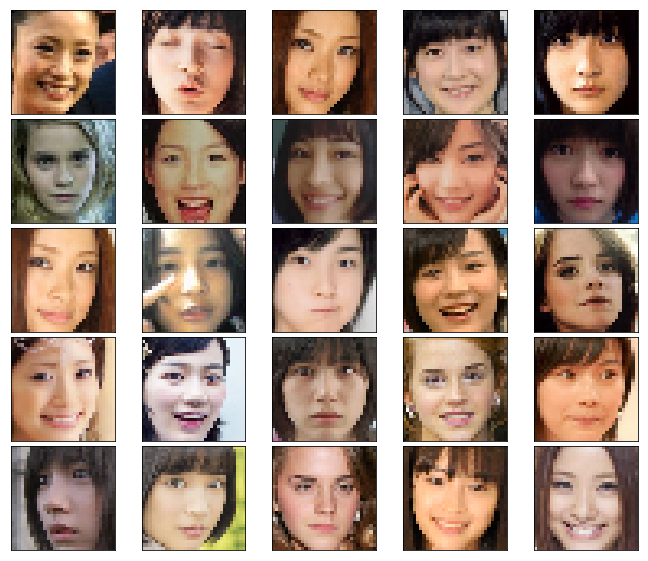

In [8]:
# 1. Flipping (horizontally)
flip_train_X = X_train[:, :, ::-1, :]

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(flip_train_X[i])

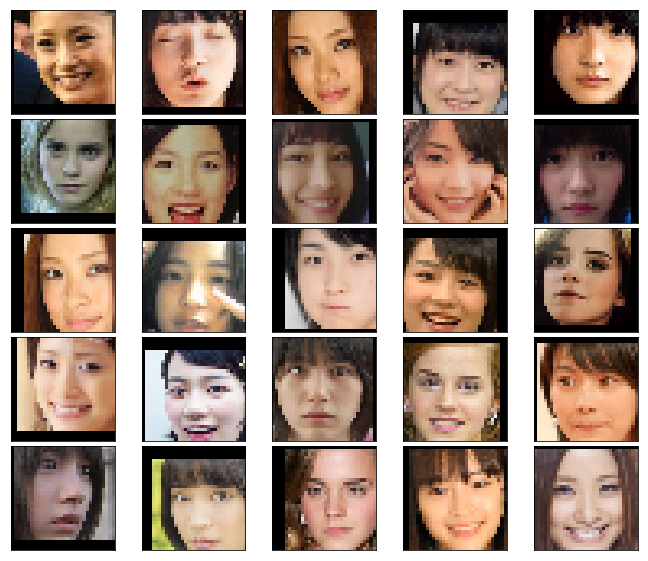

In [9]:
# 2. Random cropping
padded = np.pad(X_train, ((0, 0), (4, 4), (4, 4), (0, 0)), mode='constant')
crops = rng.randint(8, size=(len(X_train), 2))
cropped_train_X = [padded[i, c[0]:(c[0]+32), c[1]:(c[1]+32), :] for i, c in enumerate(crops)]
cropped_train_X = np.array(cropped_train_X)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(cropped_train_X[i])

In [10]:
#Train_x
old_X_train = X_train.copy()
X_len = X_train.shape[0]
X_train = np.empty([X_len*3, X_train.shape[1], X_train.shape[2], X_train.shape[3]])
for (i, pics) in enumerate([old_X_train, flip_train_X, cropped_train_X]):
    s = i * X_len
    e = s + X_len
    X_train[s:e] = pics
    
y_train = np.concatenate([y_train, y_train, y_train])

## Convet for torch

In [11]:
# For pytorch
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

## convert class vectors to binary class matrices
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [12]:
train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)

test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2)

  上戸彩  嗣永桃子  能年玲奈   上戸彩  能年玲奈  嗣永桃子 エマワトソン  能年玲奈   上戸彩  能年玲奈 エマワトソン エマワトソン  能年玲奈  能年玲奈 エマワトソン  能年玲奈 エマワトソン  能年玲奈  能年玲奈  広瀬すず  能年玲奈   上戸彩  広瀬すず  能年玲奈  能年玲奈  広瀬すず エマワトソン  広瀬すず エマワトソン  嗣永桃子 エマワトソン エマワトソン エマワトソン エマワトソン  能年玲奈  能年玲奈 エマワトソン  能年玲奈 エマワトソン   上戸彩   上戸彩  能年玲奈 エマワトソン  能年玲奈  能年玲奈   上戸彩  広瀬すず  広瀬すず  広瀬すず   上戸彩


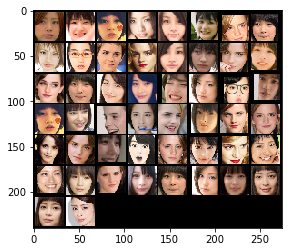

In [13]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [14]:
# 畳込みニューラルネットワークを定義する
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1a = nn.Conv2d(3, 32, 3) 
        self.conv1b = nn.Conv2d(32, 32, 3)
        self.conv2a = nn.Conv2d(32, 64, 3) 
        self.conv2b = nn.Conv2d(64, 64, 3)
        self.conv_drop = nn.Dropout2d()
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(1600, 1024)
        self.fc2   = nn.Linear(1024, 256)
        self.fc3   = nn.Linear(256, 5)

    def forward(self, x):
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.conv_drop(x)
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.conv_drop(x)
        x = x.view(-1, 1600) # exchage Tensor to flat
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
net.cuda() # use GPU
print(net)

Net (
  (conv1a): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_drop): Dropout2d (p=0.5)
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (1600 -> 1024)
  (fc2): Linear (1024 -> 256)
  (fc3): Linear (256 -> 5)
)


In [15]:
# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
# train

for epoch in range(nb_epoch):  # データセットに渡り複数回ループ
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # 入力を得る
        inputs, labels = data
 
        # それらを Variable にラップする
#         inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # parameter 勾配をゼロにする
        optimizer.zero_grad()
 
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
        # 統計表示
        check_batch_size = 30
        running_loss += loss.data[0]
        if i % check_batch_size == (check_batch_size-1):    # ミニバッチ毎に出力
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / check_batch_size))
            running_loss = 0.0

print('Finished Training')

[1,    30] loss: 1.607
[2,    30] loss: 1.422
[3,    30] loss: 1.169
[4,    30] loss: 1.093
[5,    30] loss: 1.026
[6,    30] loss: 0.973
[7,    30] loss: 0.936
[8,    30] loss: 0.896
[9,    30] loss: 0.878
[10,    30] loss: 0.862
[11,    30] loss: 0.819
[12,    30] loss: 0.777
[13,    30] loss: 0.826
[14,    30] loss: 0.753
[15,    30] loss: 0.720
[16,    30] loss: 0.725
[17,    30] loss: 0.714
[18,    30] loss: 0.667
[19,    30] loss: 0.648
[20,    30] loss: 0.670
[21,    30] loss: 0.626
[22,    30] loss: 0.622
[23,    30] loss: 0.622
[24,    30] loss: 0.581
[25,    30] loss: 0.561
[26,    30] loss: 0.575
[27,    30] loss: 0.537
[28,    30] loss: 0.516
[29,    30] loss: 0.508
[30,    30] loss: 0.484
[31,    30] loss: 0.476
[32,    30] loss: 0.496
[33,    30] loss: 0.423
[34,    30] loss: 0.446
[35,    30] loss: 0.471
[36,    30] loss: 0.444
[37,    30] loss: 0.393
[38,    30] loss: 0.438
[39,    30] loss: 0.448
[40,    30] loss: 0.382
[41,    30] loss: 0.374
[42,    30] loss: 0.377
[

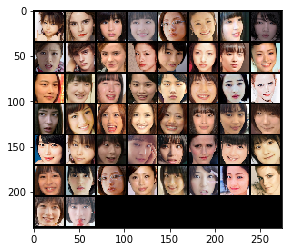

In [17]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
 
# print images
imshow(torchvision.utils.make_grid(images))

In [18]:
# train_check
outputs = net(Variable(images.cuda()))
_, predicted = torch.max(outputs.data, 1)

In [19]:
Answer = [classes[labels[j]] for j in range(len(labels))]
Predicted = [classes[predicted[j][0]] for j in range(len(labels))]
t_or_f = ['%5s'%(t == p) for t, p in zip(Answer, Predicted)]

In [20]:
print(' | '.join(['T or F', 'Answer', 'Predicted']))
for row in zip(t_or_f, Answer, Predicted):
    print(' | '.join(row))

T or F | Answer | Predicted
False | 嗣永桃子 | 広瀬すず
 True | エマワトソン | エマワトソン
 True | 広瀬すず | 広瀬すず
 True | 広瀬すず | 広瀬すず
 True | 上戸彩 | 上戸彩
 True | 上戸彩 | 上戸彩
 True | 広瀬すず | 広瀬すず
 True | 能年玲奈 | 能年玲奈
 True | 上戸彩 | 上戸彩
False | エマワトソン | 広瀬すず
 True | エマワトソン | エマワトソン
 True | 上戸彩 | 上戸彩
 True | 能年玲奈 | 能年玲奈
 True | 上戸彩 | 上戸彩
False | 広瀬すず | エマワトソン
 True | 上戸彩 | 上戸彩
False | 能年玲奈 | 上戸彩
 True | 嗣永桃子 | 嗣永桃子
 True | 広瀬すず | 広瀬すず
 True | 能年玲奈 | 能年玲奈
 True | 能年玲奈 | 能年玲奈
 True | 能年玲奈 | 能年玲奈
 True | 広瀬すず | 広瀬すず
 True | エマワトソン | エマワトソン
 True | 広瀬すず | 広瀬すず
 True | 広瀬すず | 広瀬すず
 True | 上戸彩 | 上戸彩
 True | 上戸彩 | 上戸彩
 True | 上戸彩 | 上戸彩
 True | 広瀬すず | 広瀬すず
False | 広瀬すず | 能年玲奈
False | 能年玲奈 | 嗣永桃子
 True | 能年玲奈 | 能年玲奈
False | 嗣永桃子 | 能年玲奈
 True | 能年玲奈 | 能年玲奈
 True | 広瀬すず | 広瀬すず
False | 広瀬すず | 能年玲奈
 True | エマワトソン | エマワトソン
 True | 嗣永桃子 | 嗣永桃子
 True | 嗣永桃子 | 嗣永桃子
False | 広瀬すず | 嗣永桃子
False | 能年玲奈 | 嗣永桃子
 True | 上戸彩 | 上戸彩
 True | 上戸彩 | 上戸彩
 True | 嗣永桃子 | 嗣永桃子
 True | 広瀬すず | 広瀬すず
 True | 上戸彩 | 上戸彩
 True | エマワトソン | エマワトソン
 True | 能年玲奈 

In [21]:
correct = 0
total = 0
answer_list = []
predicted_list = []

for data in test_loader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
    answer_list += list(labels.cuda())
    temp = [predicted[j][0] for j in range(len(labels))]
    predicted_list += list(temp)
    
print('Accuracy of the network test images: %d %%' % (100 * correct / total))

Accuracy of the network test images: 75 %


In [22]:
def print_cmx(y_true, y_pred, labels):
    
    cmx_data = confusion_matrix(y_true, y_pred)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True)
    plt.show()

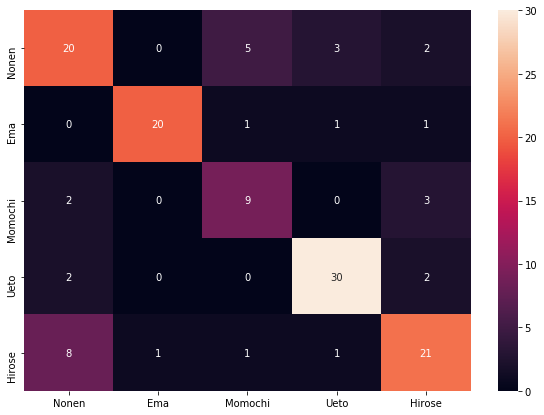

Answer = index Predicted = columns


In [23]:
classes2 =['Nonen', 'Ema', 'Momochi', 'Ueto', 'Hirose']
print_cmx(answer_list, predicted_list, classes2)
print('Answer = index', 'Predicted = columns')

In [24]:
torch.save(net, 'filename.pt')

C:\Users\shuto05\Anaconda3\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


   end